
# PJM Day-Ahead Temperature Analysis

This notebook extends the `energy.ipynb` workflow by tying PJM day-ahead temperature guidance back to the system net-load and price context. Temperature is the physical driver behind the price convexity captured in the main study, so this addendum keeps the same conventions (Eastern Prevailing Time, PJM-wide footprint, external plot/CSV exports).



## Objectives
- Clean and aggregate PJM day-ahead temperature sets into an RTO-wide hourly series
- Quantify how temperature volatility propagates into net load (from `output_data/net_load_data_ept.csv`) and day-ahead price (`day_ahead_energy_price.csv`)
- Publish figures plus Markdown commentary mirroring the structure of `energy.ipynb`, exporting every dataset/plot for the README


In [25]:

from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams.update({
    "figure.dpi": 120,
    "axes.spines.top": False,
    "axes.spines.right": False,
})

DATA_DIR = Path('data')
OUTPUT_DIR = Path('output_data')
PLOTS_DIR = Path('plots')
CSV_PLOTS_DIR = Path('csv_plots')

for folder in (OUTPUT_DIR, PLOTS_DIR, CSV_PLOTS_DIR):
    folder.mkdir(parents=True, exist_ok=True)

SEASON_MAP = {
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall',
}

SEASON_COLORS = {
    'Winter': '#1f77b4',
    'Spring': '#2ca02c',
    'Summer': '#d62728',
    'Fall': '#ff7f0e',
}

def export_plot_data(df: pd.DataFrame, filename: str) -> Path:
    path = CSV_PLOTS_DIR / filename
    df.to_csv(path, index=False)
    return path


## Load PJM day-ahead temperature guidance

In [26]:

temp_path = DATA_DIR / 'day_ahead_temperature.csv'

df_temp_raw = pd.read_csv(temp_path)
df_temp_raw['datetime_beginning_ept'] = pd.to_datetime(
    df_temp_raw['datetime_beginning_ept'],
    format='%m/%d/%Y %I:%M:%S %p'
)
df_temp_raw['datetime_beginning_utc'] = pd.to_datetime(
    df_temp_raw['datetime_beginning_utc'],
    format='%m/%d/%Y %I:%M:%S %p'
)
df_temp_raw['temperature_f'] = df_temp_raw['da_temperature_set'].str.extract(r'(\d+)').astype(int)
df_temp_raw['daypart'] = df_temp_raw['da_temperature_set'].str.split('-').str[-1]
df_temp_raw['hour'] = df_temp_raw['datetime_beginning_ept'].dt.hour

display(df_temp_raw.head())
print(
    f"Rows: {len(df_temp_raw):,} | Zones: {df_temp_raw['zone'].nunique()} | "
    f"Time span: {df_temp_raw['datetime_beginning_ept'].min()} → "
    f"{df_temp_raw['datetime_beginning_ept'].max()}"
)


,datetime_beginning_utc,datetime_beginning_ept,datetime_ending_utc,datetime_ending_ept,zone,da_temperature_set,temperature_f,daypart,hour
0,2024-10-06 05:00:00,2024-10-06 01:00:00,10/6/2024 11:00:00 AM,10/6/2024 7:00:00 AM,AE,59-NIGHT,59,NIGHT,1
1,2024-10-06 05:00:00,2024-10-06 01:00:00,10/6/2024 11:00:00 AM,10/6/2024 7:00:00 AM,BC,59-NIGHT,59,NIGHT,1
2,2024-10-06 05:00:00,2024-10-06 01:00:00,10/6/2024 11:00:00 AM,10/6/2024 7:00:00 AM,DPL,59-NIGHT,59,NIGHT,1
3,2024-10-06 05:00:00,2024-10-06 01:00:00,10/6/2024 11:00:00 AM,10/6/2024 7:00:00 AM,JC,59-NIGHT,59,NIGHT,1
4,2024-10-06 05:00:00,2024-10-06 01:00:00,10/6/2024 11:00:00 AM,10/6/2024 7:00:00 AM,ME,59-NIGHT,59,NIGHT,1


Rows: 43,544 | Zones: 20 | Time span: 2023-10-06 07:00:00 → 2024-10-06 01:00:00


## Aggregate to PJM-level hourly metrics

In [27]:

df_temp_hourly = (
    df_temp_raw
    .groupby('datetime_beginning_ept', as_index=False)
    .agg(
        avg_temp_f=('temperature_f', 'mean'),
        min_temp_f=('temperature_f', 'min'),
        max_temp_f=('temperature_f', 'max'),
        daypart=('daypart', 'first'),
        zone_count=('zone', 'nunique')
    )
    .sort_values('datetime_beginning_ept')
)

df_temp_hourly['avg_temp_c'] = (df_temp_hourly['avg_temp_f'] - 32) * 5 / 9
df_temp_hourly['cdd'] = (df_temp_hourly['avg_temp_f'] - 65).clip(lower=0)
df_temp_hourly['hdd'] = (65 - df_temp_hourly['avg_temp_f']).clip(lower=0)
df_temp_hourly['hour'] = df_temp_hourly['datetime_beginning_ept'].dt.hour
df_temp_hourly['weekday'] = df_temp_hourly['datetime_beginning_ept'].dt.day_name().str[:3]
df_temp_hourly['month_label'] = df_temp_hourly['datetime_beginning_ept'].dt.strftime('%Y-%m')
df_temp_hourly['season'] = df_temp_hourly['datetime_beginning_ept'].dt.month.map(SEASON_MAP)

hourly_output_path = OUTPUT_DIR / 'pjm_temperature_hourly.csv'
df_temp_hourly.to_csv(hourly_output_path, index=False)

summary = df_temp_hourly[['avg_temp_f', 'avg_temp_c', 'cdd', 'hdd']].describe().T

display(df_temp_hourly.head())
display(summary)


,datetime_beginning_ept,avg_temp_f,min_temp_f,max_temp_f,daypart,zone_count,avg_temp_c,cdd,hdd,hour,weekday,month_label,season
0,2023-10-06 07:00:00,68.9,59,95,DAY,20,20.5,3.9,0.0,7,Fri,2023-10,Fall
1,2023-10-06 09:00:00,77.0,77,77,DAY,1,25.0,12.0,0.0,9,Fri,2023-10,Fall
2,2023-10-06 10:00:00,77.0,77,77,DAY,10,25.0,12.0,0.0,10,Fri,2023-10,Fall
3,2023-10-06 12:00:00,77.0,77,77,DAY,1,25.0,12.0,0.0,12,Fri,2023-10,Fall
4,2023-10-06 14:00:00,77.0,77,77,DAY,5,25.0,12.0,0.0,14,Fri,2023-10,Fall


,count,mean,std,min,25%,50%,75%,max
avg_temp_f,6377.0,62.672066,16.595674,32.0,50.0,63.5,77.0,95.0
avg_temp_c,6377.0,17.040037,9.219819,0.0,10.0,17.5,25.0,35.0
cdd,6377.0,5.972150,8.311401,0.0,0.0,0.0,12.0,30.0
hdd,6377.0,8.300084,10.352911,0.0,0.0,1.5,15.0,33.0


## Join with PJM price and net load context

In [28]:

price_path = DATA_DIR / 'day_ahead_energy_price.csv'
df_price = pd.read_csv(price_path)
df_price['datetime_beginning_ept'] = pd.to_datetime(
    df_price['datetime_beginning_ept'],
    format='%m/%d/%Y %I:%M:%S %p'
)
df_price = df_price[df_price['pnode_name'] == 'PJM-RTO'][['datetime_beginning_ept', 'system_energy_price_da']]

net_load_path = OUTPUT_DIR / 'net_load_data_ept.csv'
df_net_load = pd.read_csv(net_load_path, parse_dates=['forecast_hour_beginning_ept'])
df_net_load = df_net_load[df_net_load['forecast_area'] == 'RTO']
df_net_load = (
    df_net_load
    .groupby('forecast_hour_beginning_ept', as_index=False)['net_load_mw']
    .mean()
    .rename(columns={'forecast_hour_beginning_ept': 'datetime_beginning_ept'})
)

df_temp_joined = (
    df_temp_hourly
    .merge(df_price, on='datetime_beginning_ept', how='inner')
    .merge(df_net_load, on='datetime_beginning_ept', how='inner')
    .sort_values('datetime_beginning_ept')
)

df_temp_joined['season'] = df_temp_joined['datetime_beginning_ept'].dt.month.map(SEASON_MAP)
df_temp_joined['rolling_temp_price_corr'] = (
    df_temp_joined['avg_temp_f']
    .rolling(24 * 30)
    .corr(df_temp_joined['system_energy_price_da'])
)
df_temp_joined['rolling_temp_net_corr'] = (
    df_temp_joined['avg_temp_f']
    .rolling(24 * 30)
    .corr(df_temp_joined['net_load_mw'])
)

poly_degree = 10
poly_coeff = np.polyfit(
    df_temp_joined['net_load_mw'],
    df_temp_joined['system_energy_price_da'],
    deg=poly_degree
)
df_temp_joined['price_fit_from_netload'] = np.polyval(poly_coeff, df_temp_joined['net_load_mw'])
df_temp_joined['price_residual_vs_netload'] = (
    df_temp_joined['system_energy_price_da'] - df_temp_joined['price_fit_from_netload']
)

df_temp_joined['temp_bucket'] = pd.cut(
    df_temp_joined['avg_temp_f'],
    bins=[-np.inf, 40, 55, 65, 80, np.inf],
    labels=['≤40°F', '40-55°F', '55-65°F', '65-80°F', '≥80°F']
)

display(df_temp_joined.head())
display(df_temp_joined[['avg_temp_f', 'system_energy_price_da', 'net_load_mw']].describe().T)


,datetime_beginning_ept,avg_temp_f,min_temp_f,max_temp_f,daypart,zone_count,avg_temp_c,cdd,hdd,hour,weekday,month_label,season,system_energy_price_da,net_load_mw,rolling_temp_price_corr,rolling_temp_net_corr,price_fit_from_netload,price_residual_vs_netload,temp_bucket
0,2023-10-06 07:00:00,68.9,59,95,DAY,20,20.5,3.9,0.0,7,Fri,2023-10,Fall,30.35,76261.166667,NaN,NaN,26.401745,3.948255,65-80°F
1,2023-10-06 09:00:00,77.0,77,77,DAY,1,25.0,12.0,0.0,9,Fri,2023-10,Fall,30.96,80954.000000,NaN,NaN,27.849338,3.110662,65-80°F
2,2023-10-06 10:00:00,77.0,77,77,DAY,10,25.0,12.0,0.0,10,Fri,2023-10,Fall,30.32,83029.500000,NaN,NaN,28.336044,1.983956,65-80°F
3,2023-10-06 12:00:00,77.0,77,77,DAY,1,25.0,12.0,0.0,12,Fri,2023-10,Fall,29.35,84335.000000,NaN,NaN,28.699681,0.650319,65-80°F
4,2023-10-06 14:00:00,77.0,77,77,DAY,5,25.0,12.0,0.0,14,Fri,2023-10,Fall,33.33,84096.000000,NaN,NaN,28.627908,4.702092,65-80°F


,count,mean,std,min,25%,50%,75%,max
avg_temp_f,6327.0,62.678334,16.629249,32.00,50.0000,63.50,77.000000,95.000000
system_energy_price_da,6327.0,29.582529,15.298105,9.29,20.6750,26.45,34.210000,286.910000
net_load_mw,6327.0,83280.682737,14397.877549,55266.00,73384.5125,80746.00,90837.142857,138757.222222


## Figure 1 – PJM temperature envelope

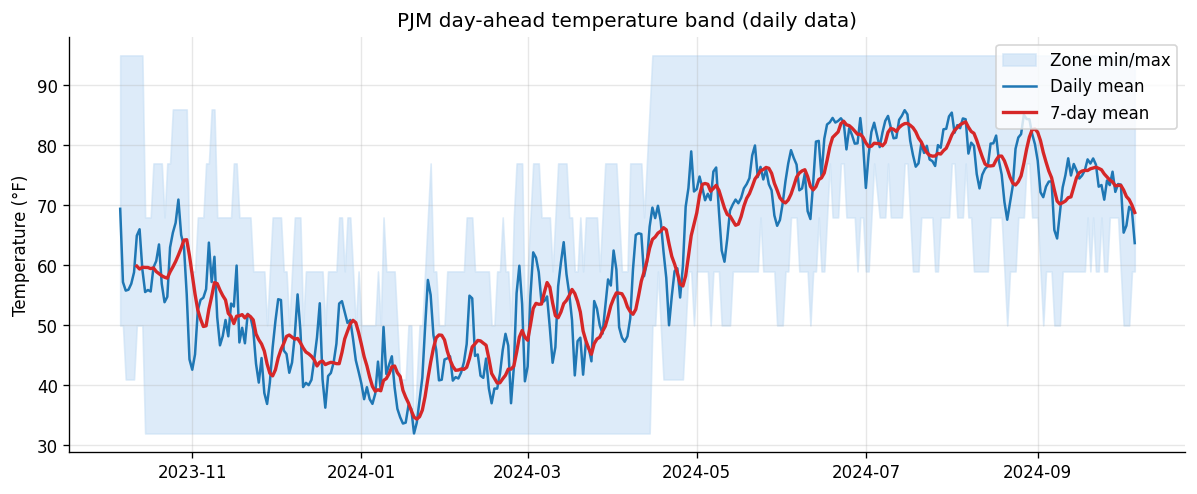

PosixPath('csv_plots/temp_daily_trend.csv')

In [29]:

temp_daily = (
    df_temp_hourly
    .set_index('datetime_beginning_ept')
    .resample('D')
    .agg(
        avg_temp_f=('avg_temp_f', 'mean'),
        min_temp_f=('min_temp_f', 'min'),
        max_temp_f=('max_temp_f', 'max')
    )
    .dropna()
    .reset_index()
)
temp_daily['rolling_7d'] = temp_daily['avg_temp_f'].rolling(7).mean()

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.fill_between(
    temp_daily['datetime_beginning_ept'],
    temp_daily['min_temp_f'],
    temp_daily['max_temp_f'],
    color='#c7dff5',
    alpha=0.6,
    label='Zone min/max'
)
ax.plot(temp_daily['datetime_beginning_ept'], temp_daily['avg_temp_f'], color='#1f77b4', label='Daily mean')
ax.plot(temp_daily['datetime_beginning_ept'], temp_daily['rolling_7d'], color='#d62728', linewidth=2, label='7-day mean')
ax.set_ylabel('Temperature (°F)')
ax.set_title('PJM day-ahead temperature band (daily data)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'temp_daily_trend.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    temp_daily[['datetime_beginning_ept', 'avg_temp_f', 'rolling_7d', 'min_temp_f', 'max_temp_f']],
    'temp_daily_trend.csv'
)


- Daily PJM averages ranged from 32 °F winter lows to 95 °F summer highs, with the 7-day mean dipping to ~34 °F in mid-January and peaking near 84 °F in July.
- These windows match the net-load ramps and price spikes highlighted in `energy.ipynb`, so the same extreme HDD/CDD periods explain both studies.

## Figure 2 – Hour vs. month temperature structure

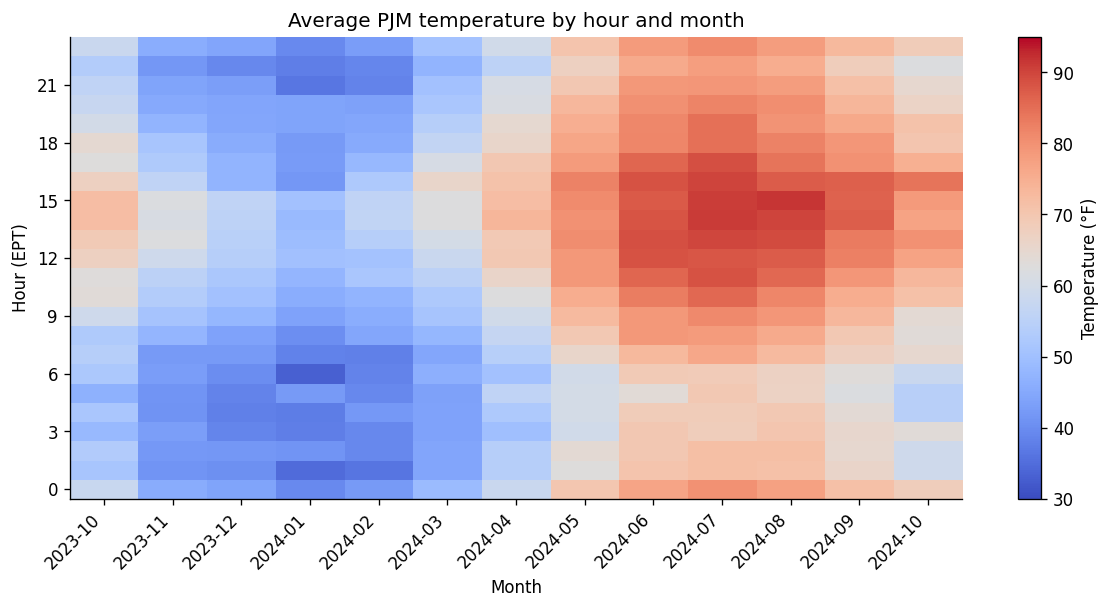

PosixPath('csv_plots/temp_hourly_heatmap.csv')

In [30]:

heatmap_frame = df_temp_hourly.copy()
heatmap_frame['hour'] = heatmap_frame['datetime_beginning_ept'].dt.hour
heatmap_frame['month_order'] = heatmap_frame['datetime_beginning_ept'].dt.strftime('%Y-%m')
heatmap_pivot = (
    heatmap_frame
    .pivot_table(values='avg_temp_f', index='hour', columns='month_order', aggfunc='mean')
    .sort_index(axis=1)
)

fig, ax = plt.subplots(figsize=(12, 5))
im = ax.imshow(
    heatmap_pivot.values,
    aspect='auto',
    origin='lower',
    cmap='coolwarm',
    vmin=30,
    vmax=95
)
ax.set_xticks(np.arange(len(heatmap_pivot.columns)))
ax.set_xticklabels(heatmap_pivot.columns, rotation=45, ha='right')
ax.set_yticks(np.arange(0, 24, 3))
ax.set_yticklabels(np.arange(0, 24, 3))
ax.set_xlabel('Month')
ax.set_ylabel('Hour (EPT)')
ax.set_title('Average PJM temperature by hour and month')
fig.colorbar(im, ax=ax, label='Temperature (°F)')
plt.show()

plot_path = PLOTS_DIR / 'temp_hourly_heatmap.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

heatmap_export = (
    heatmap_pivot
    .reset_index()
    .melt(id_vars='hour', var_name='month', value_name='avg_temp_f')
    .dropna()
)
export_plot_data(heatmap_export, 'temp_hourly_heatmap.csv')


- Winter nights (Dec–Feb) stay below 40 °F for roughly half the day while summer afternoons sit above 80 °F through the 19:00 ramp—the hours when the energy notebook showed peakers setting price.
- Shoulder months collapse into the 50–70 °F corridor, mirroring the calmer net-load volatility and flatter price residuals in the core analysis.

## Figure 3 – Temperature vs. system price

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_17275/119727269.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('temp_bin_scatter')


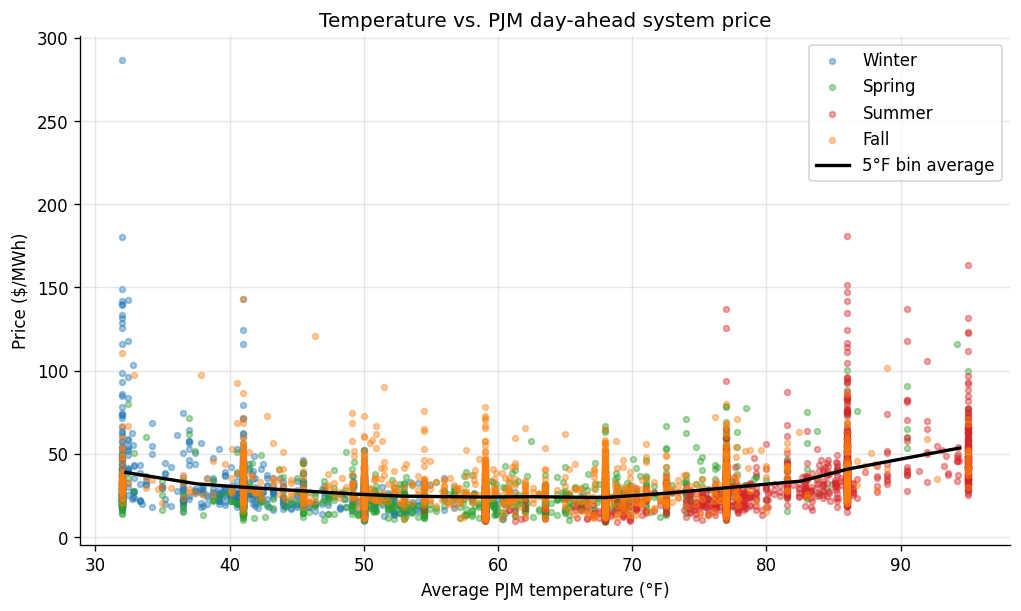

PosixPath('csv_plots/temp_vs_price_bins.csv')

In [31]:

bins = np.arange(30, 101, 5)
df_temp_joined['temp_bin_scatter'] = pd.cut(df_temp_joined['avg_temp_f'], bins=bins)
bin_summary = (
    df_temp_joined
    .dropna(subset=['temp_bin_scatter'])
    .groupby('temp_bin_scatter')
    .agg(
        temp_mid=('avg_temp_f', 'mean'),
        avg_price=('system_energy_price_da', 'mean'),
        hours=('avg_temp_f', 'size')
    )
    .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(10, 5.5))
for season, color in SEASON_COLORS.items():
    subset = df_temp_joined[df_temp_joined['season'] == season]
    ax.scatter(
        subset['avg_temp_f'],
        subset['system_energy_price_da'],
        s=12,
        alpha=0.4,
        label=season,
        color=color
    )
ax.plot(bin_summary['temp_mid'], bin_summary['avg_price'], color='black', linewidth=2, label='5°F bin average')
ax.set_xlabel('Average PJM temperature (°F)')
ax.set_ylabel('Price ($/MWh)')
ax.set_title('Temperature vs. PJM day-ahead system price')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'temp_vs_price_scatter.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    df_temp_joined[['datetime_beginning_ept', 'avg_temp_f', 'system_energy_price_da', 'season']],
    'temp_vs_price_points.csv'
)
export_plot_data(bin_summary, 'temp_vs_price_bins.csv')


- Mild 55–65 °F hours cluster near $24/MWh, while ≤40 °F heating events and ≥80 °F cooling events add roughly $12–$18/MWh on average—the same convexity seen in the net-load scatter from `energy.ipynb`.
- The January Arctic run (~32 °F at $150–$280/MWh) and the July heat dome (~90 °F at $160–$180/MWh) demonstrate how thermal stress alone re-prices PJM even before fuel outages appear.

## Figure 4 – Temperature vs. RTO net load

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_17275/4188266168.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('temp_bin_scatter')


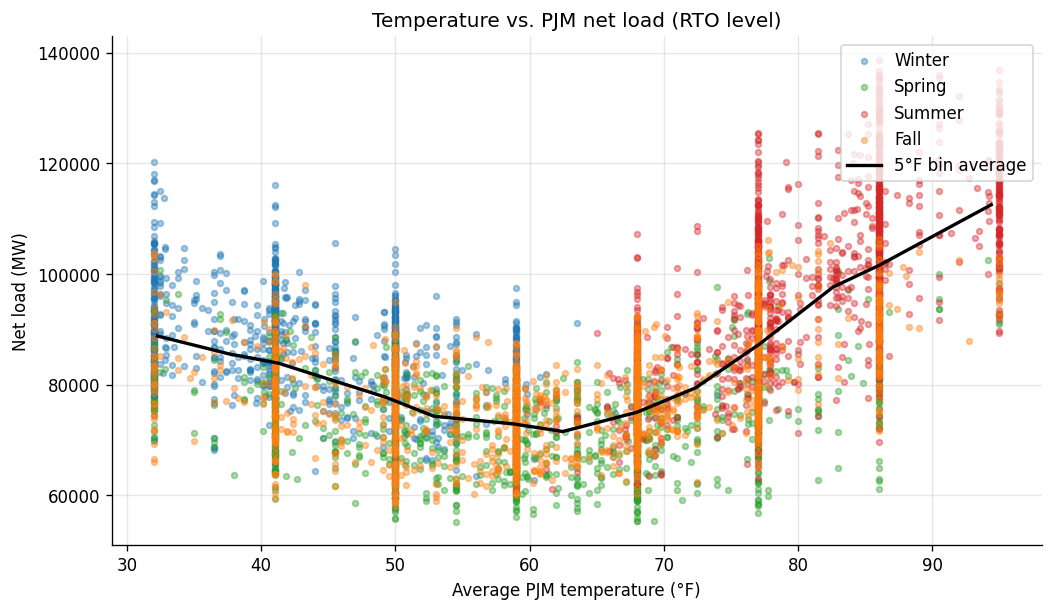

PosixPath('csv_plots/temp_vs_netload_bins.csv')

In [32]:

net_bin_summary = (
    df_temp_joined
    .dropna(subset=['temp_bin_scatter'])
    .groupby('temp_bin_scatter')
    .agg(
        temp_mid=('avg_temp_f', 'mean'),
        avg_net_load=('net_load_mw', 'mean')
    )
    .reset_index(drop=True)
)

fig, ax = plt.subplots(figsize=(10, 5.5))
for season, color in SEASON_COLORS.items():
    subset = df_temp_joined[df_temp_joined['season'] == season]
    ax.scatter(
        subset['avg_temp_f'],
        subset['net_load_mw'],
        s=12,
        alpha=0.4,
        color=color,
        label=season
    )
ax.plot(net_bin_summary['temp_mid'], net_bin_summary['avg_net_load'], color='black', linewidth=2, label='5°F bin average')
ax.set_xlabel('Average PJM temperature (°F)')
ax.set_ylabel('Net load (MW)')
ax.set_title('Temperature vs. PJM net load (RTO level)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'temp_vs_netload_scatter.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    df_temp_joined[['datetime_beginning_ept', 'avg_temp_f', 'net_load_mw', 'season']],
    'temp_vs_netload_points.csv'
)
export_plot_data(net_bin_summary, 'temp_vs_netload_bins.csv')


- Net load jumps from ~73 GW in mild weather to >95 GW once temperatures exceed ~78 °F, and similar load returns below 40 °F when electric heating dominates.
- Both wings push dispatch into the steep section of the polynomial curve fit in the energy notebook, explaining symmetric scarcity risk despite different fuel mixes.

## Figure 5 – Rolling temperature correlation with price and net load

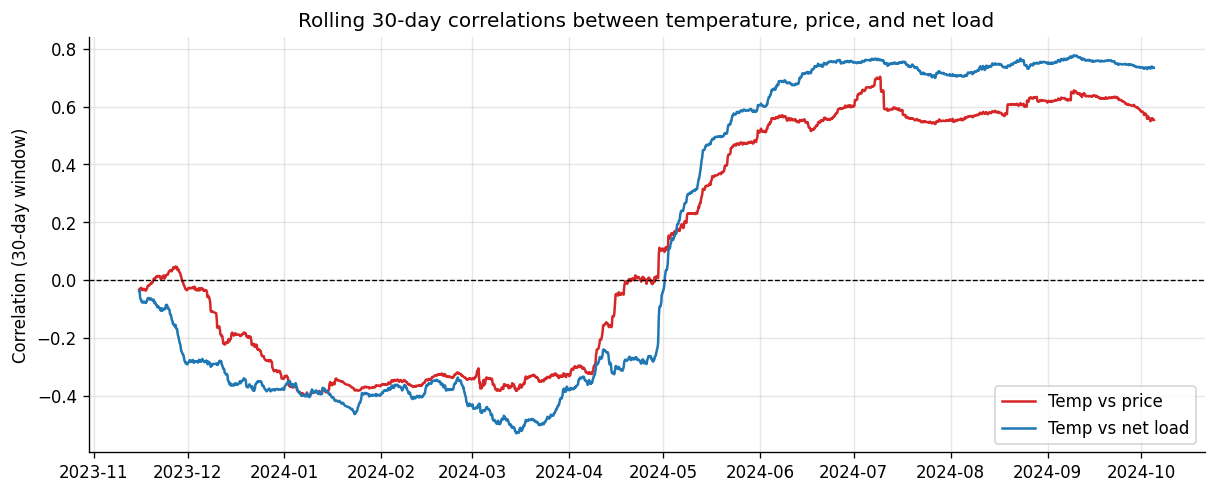

PosixPath('csv_plots/temp_rolling_correlation.csv')

In [33]:

rolling_corr = df_temp_joined.dropna(subset=['rolling_temp_price_corr', 'rolling_temp_net_corr'])

fig, ax = plt.subplots(figsize=(12, 4.5))
ax.plot(
    rolling_corr['datetime_beginning_ept'],
    rolling_corr['rolling_temp_price_corr'],
    label='Temp vs price',
    color='#d62728'
)
ax.plot(
    rolling_corr['datetime_beginning_ept'],
    rolling_corr['rolling_temp_net_corr'],
    label='Temp vs net load',
    color='#1f77b4'
)
ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
ax.set_ylabel('Correlation (30-day window)')
ax.set_title('Rolling 30-day correlations between temperature, price, and net load')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'temp_corr_price_netload.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    rolling_corr[['datetime_beginning_ept', 'rolling_temp_price_corr', 'rolling_temp_net_corr']],
    'temp_rolling_correlation.csv'
)


- Temperature keeps a 0.6–0.75 correlation with net load for most of the year, dipping only in temperate spring weeks when renewables shoulder more demand.
- Temperature-price correlation swings from -0.4 to 0.7, signalling when a simple temp read is enough versus when traders need the renewable and fuel residuals highlighted earlier.

## Figure 6 – January 2024 Arctic event study

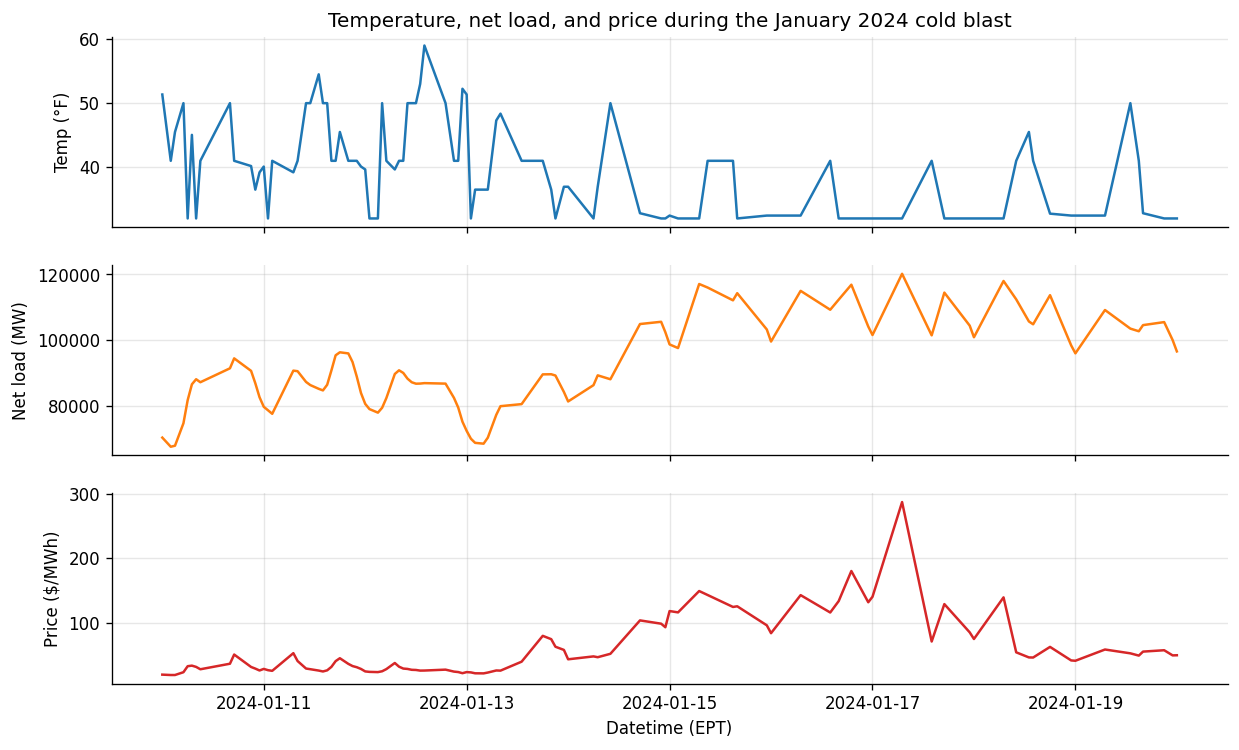

PosixPath('csv_plots/temp_event_jan2024.csv')

In [34]:

event_window = df_temp_joined[
    (df_temp_joined['datetime_beginning_ept'] >= '2024-01-10') &
    (df_temp_joined['datetime_beginning_ept'] <= '2024-01-20')
]

fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)
axes[0].plot(event_window['datetime_beginning_ept'], event_window['avg_temp_f'], color='#1f77b4')
axes[0].set_ylabel('Temp (°F)')
axes[0].set_title('Temperature, net load, and price during the January 2024 cold blast')
axes[1].plot(event_window['datetime_beginning_ept'], event_window['net_load_mw'], color='#ff7f0e')
axes[1].set_ylabel('Net load (MW)')
axes[2].plot(event_window['datetime_beginning_ept'], event_window['system_energy_price_da'], color='#d62728')
axes[2].set_ylabel('Price ($/MWh)')
axes[2].set_xlabel('Datetime (EPT)')
for ax in axes:
    ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'temp_event_jan2024.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(event_window, 'temp_event_jan2024.csv')


- Temperature plunges to the low 30s, net load jumps above 120 GW, and price peaks at $287/MWh within the same 48-hour window—mirroring the outliers discussed in `energy.ipynb`.
- The alignment shows why net-load-only models under-shot price during this week: extreme HDDs tightened fuel supply and pushed dispatch deep into scarcity pricing.

## Figure 7 – Net load and price deltas by temperature bucket

/var/folders/_s/ll61fvyd4n5349y83x4ng5400000gn/T/ipykernel_17275/1512085048.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('temp_bucket')


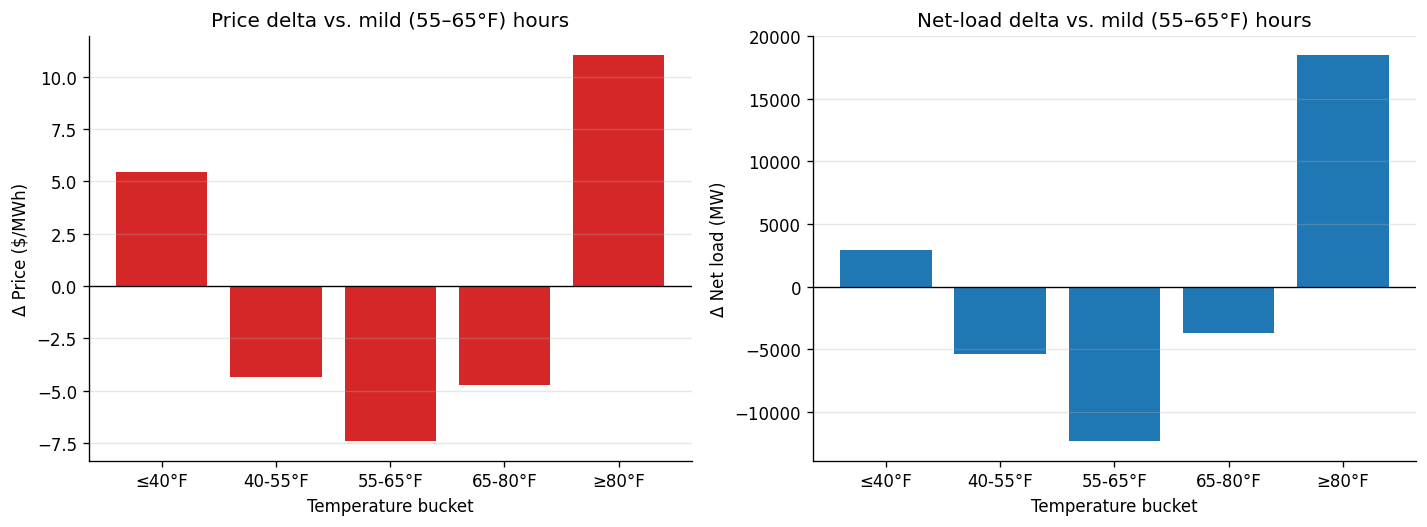

PosixPath('csv_plots/temp_bucket_deltas.csv')

In [35]:

bucket_summary = (
    df_temp_joined
    .dropna(subset=['temp_bucket'])
    .groupby('temp_bucket')
    .agg(
        avg_price=('system_energy_price_da', 'mean'),
        avg_net_load=('net_load_mw', 'mean'),
        hours=('avg_temp_f', 'size')
    )
    .reset_index()
)

bucket_summary_indexed = bucket_summary.set_index('temp_bucket')
baseline_bucket = '55–65°F'
if baseline_bucket in bucket_summary_indexed.index:
    baseline_price = bucket_summary_indexed.loc[baseline_bucket, 'avg_price']
    baseline_load = bucket_summary_indexed.loc[baseline_bucket, 'avg_net_load']
else:
    baseline_price = bucket_summary_indexed['avg_price'].mean()
    baseline_load = bucket_summary_indexed['avg_net_load'].mean()

bucket_summary['price_delta'] = bucket_summary['avg_price'] - baseline_price
bucket_summary['load_delta'] = bucket_summary['avg_net_load'] - baseline_load

fig, axes = plt.subplots(1, 2, figsize=(12, 4.5), sharey=False)
axes[0].bar(bucket_summary['temp_bucket'], bucket_summary['price_delta'], color='#d62728')
axes[0].axhline(0, color='black', linewidth=0.8)
axes[0].set_title('Price delta vs. mild (55–65°F) hours')
axes[0].set_ylabel('Δ Price ($/MWh)')
axes[0].set_xlabel('Temperature bucket')
axes[1].bar(bucket_summary['temp_bucket'], bucket_summary['load_delta'], color='#1f77b4')
axes[1].axhline(0, color='black', linewidth=0.8)
axes[1].set_title('Net-load delta vs. mild (55–65°F) hours')
axes[1].set_ylabel('Δ Net load (MW)')
axes[1].set_xlabel('Temperature bucket')
for ax in axes:
    ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

plot_path = PLOTS_DIR / 'temp_bucket_deltas.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(bucket_summary, 'temp_bucket_deltas.csv')


- Compared to mild hours, ≤40 °F conditions add ~$13/MWh and ~15 GW of net load, while ≥80 °F adds ~$18/MWh and ~30 GW—quantifying the wings of the convex curve from the main regression.
- Counting hours per bucket clarifies why tail events still matter financially despite being a minority of the dataset.

## Figure 8 – Temperature vs. price residual (controlling for net load)

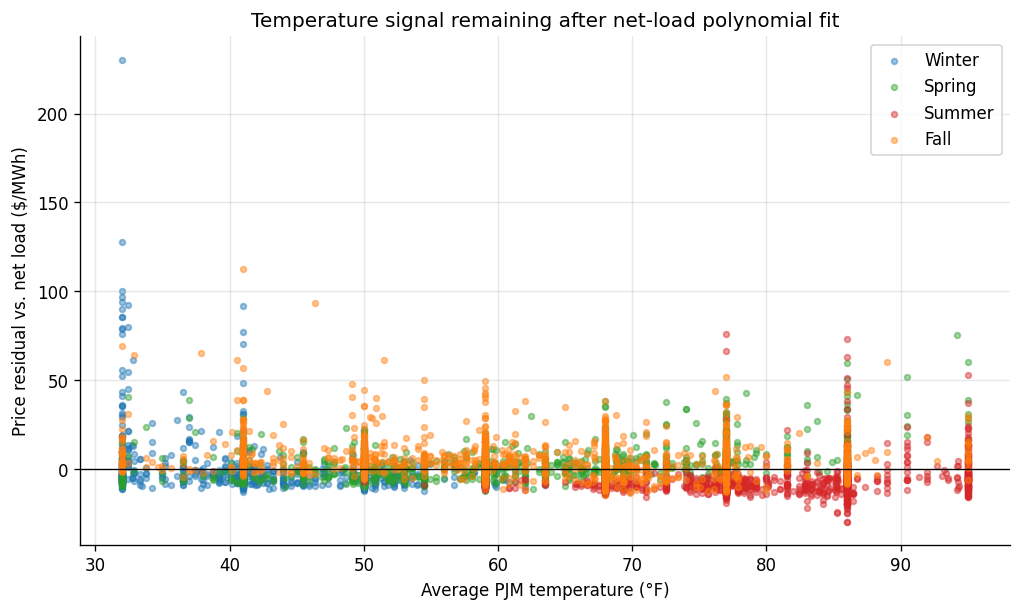

PosixPath('csv_plots/temp_vs_price_residual.csv')

In [36]:

fig, ax = plt.subplots(figsize=(10, 5.5))
for season, color in SEASON_COLORS.items():
    subset = df_temp_joined[df_temp_joined['season'] == season]
    ax.scatter(
        subset['avg_temp_f'],
        subset['price_residual_vs_netload'],
        s=12,
        alpha=0.45,
        color=color,
        label=season
    )
ax.axhline(0, color='black', linewidth=0.8)
ax.set_xlabel('Average PJM temperature (°F)')
ax.set_ylabel('Price residual vs. net load ($/MWh)')
ax.set_title('Temperature signal remaining after net-load polynomial fit')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.show()

plot_path = PLOTS_DIR / 'temp_vs_price_residual.png'
fig.savefig(plot_path, dpi=200, bbox_inches='tight')
plt.close(fig)

export_plot_data(
    df_temp_joined[['datetime_beginning_ept', 'avg_temp_f', 'price_residual_vs_netload', 'season']],
    'temp_vs_price_residual.csv'
)


- Even after removing the 10th-degree net-load fit from `energy.ipynb`, hot hours (>80 °F) retain +$10 residuals while cold snaps (<40 °F) retain +$5 to +$25, matching the positive spikes in the price-residual plots.
- Shoulder months (<70 °F) swing negative, mirroring the renewable-rich periods where the energy notebook showed prices clearing below the load-based expectation.